In [1]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

## Importation des données
Sans surprises, on utilisera de l'api Yahoo finance (faute de mieux).
On prendra les cours journaliers sur les 5 dernières années.

In [2]:
def load_data(stock_name):
    resp = requests.get("https://query1.finance.yahoo.com/v8/finance/chart/" + stock_name + "?region=US&lang=en-US&interval=1d&&range=5y", headers={'USER-AGENT': "Mozilla/5.0"})
    vals = json.loads(resp.text)
    print(stock_name, len(vals['chart']['result'][0]['indicators']['quote'][0]['close']))
    return np.array(vals['chart']['result'][0]['indicators']['quote'][0]['close'])[0:1258]

stocks = [
    "PMBCX", "JANEX", "PEMGX", "OII", "PUMP", "NOK", "CVE", # fonds
    "GOLD", "OXY", "VALE", "VIGIX", "VIGAX", "SAP", # fonds
    "JCQ.PA", "AI.PA", "PCA.PA", # matières premières
    "AIR.PA", "BA", "LMT", "BAESY", "BDRAF",# aero
    "GM", "VLKAF", "TM", "BMW.DE", "F" # auto

]
dataset = np.array([load_data(stock) for stock in stocks])

PMBCX 1259
JANEX 1259
PEMGX 1259
OII 1259
PUMP 1259
NOK 1259
CVE 1259
GOLD 1259
OXY 1259
VALE 1259
VIGIX 1259
VIGAX 1259
SAP 1259
JCQ.PA 1282
AI.PA 1282
PCA.PA 1282
AIR.PA 1282
BA 1259
LMT 1259
BAESY 1259
BDRAF 1259
GM 1259
VLKAF 1259
TM 1259
BMW.DE 1268
F 1259


Un petit netoyage de ces données s'impose :

In [3]:
# Clean du dataset
for line in dataset:
    for i in range(len(line)):
        if line[i] == None:
            line[i] = line[i-1]

print(dataset.shape)

(26, 1258)


On peut maintenant essayer d'afficher les cours (normalisés, sinon on ne voit rien...) des actions/indices suivis.

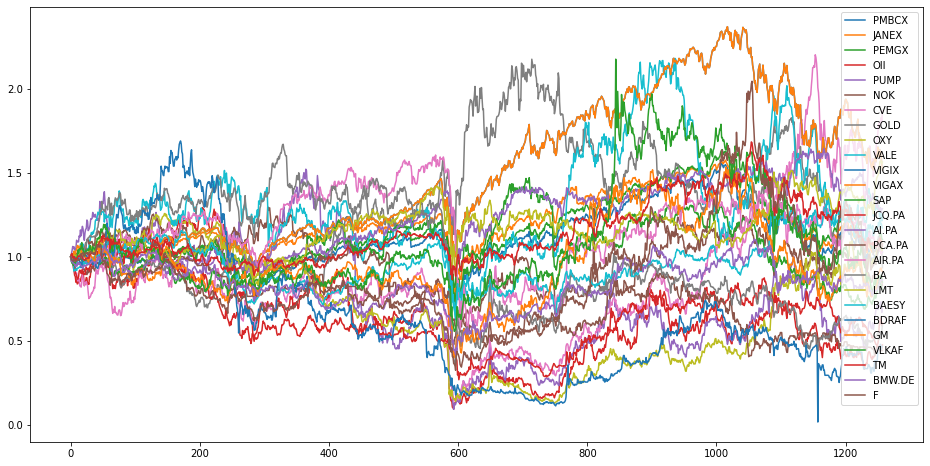

In [4]:
plt.figure(figsize=(16,8))
for i in range(len(dataset)):
    plt.plot(dataset[i] / dataset[i][0], label=stocks[i])
plt.legend()

Sans surprise, la chute généralisée des marchées de Mars 2020 est imédiatement perceptible...

## Simulations

On définit maintenant notre fonction définissant la performance d'un titre sur la période données.

In [5]:
def returns(serie):
    return ((serie[-1] / serie[0])-1)*100

Nous allons ici essayer différentes fonctions pour mesurer la variance d'un portefeuille, pour ensuite en comparer les résultats. Dans un premier temps, on utilisera la bonne vieille formule de la variance empirique.

In [17]:
def variance(serie):
    return np.std(serie)

In [33]:
def run_simulation(r=returns, var=variance, iters=1000):
    returnList = []
    stdList = []
    min_var, min_var_serie = 100000, []
    max_var, max_var_serie = 0, []

    plt.figure(figsize=(16,8))

    for i in range(iters):
        mask = np.random.randint(0, 2, size=len(stocks))
        coeff = np.random.random(len(stocks)) * mask
        coeff = coeff / np.sum(coeff)
        coeff = coeff / dataset[:,0]
        serie = dataset.T @ np.array([coeff]).T

        returnList.append(r(serie))
        series_var = var(serie)

        if min_var > series_var:
            min_var = series_var
            min_var_serie = serie
        if max_var < series_var:
            max_var = series_var
            max_var_serie = serie

        stdList.append(series_var)

    
    plt.figure(figsize=(10,6))
    plt.xlabel("Variance")
    plt.ylabel("Return (%)")
    plt.title("Performance en fonction de la variance pourn " + str(iters) + " tirages")
    plt.scatter(stdList, returnList)
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(min_var_serie, label="Portefeuille à la plus faible variance (" + str(min_var) + ")")
    plt.plot(max_var_serie, label="Portefeuille à la plus forte variance (" + str(max_var) + ")")
    plt.legend()
    plt.show()

<Figure size 1152x576 with 0 Axes>

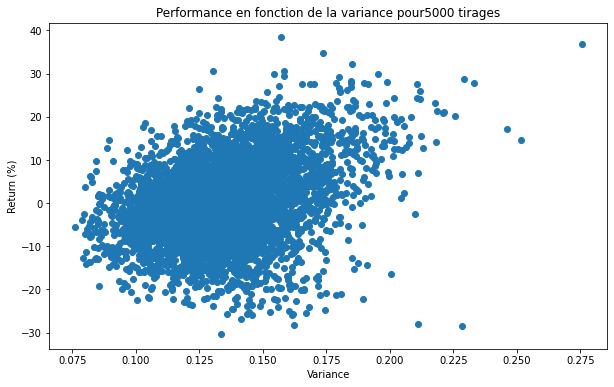

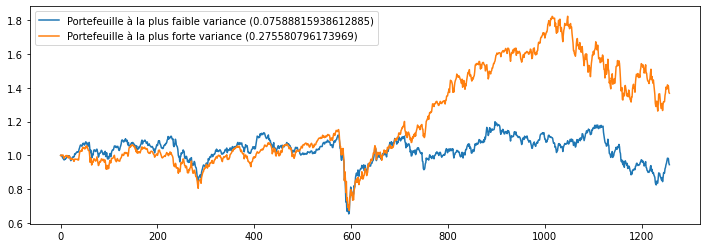

In [40]:
run_simulation(iters=5000)

On constate ici que bien que les portefeuilles affichent des variances différentes, aucun n'a la belle forme régulière que l'on aimerai constater.
Les deux portefeuilles suivent d'importants mouvements, mais pour des mouvements similaires, le portefeuille avec la plus faible performance se retrouve avec une variance plus faible.
C'est en effet du à la formule de la variance, qui caclul les écarts à la moyenne, favorisant ainsi la stagnation.
Pour pallier cet effet indésirable (qui a envie de voir son portefeuille stagner ?), ma première intuition est de copmparer les données à une moyenne mobile calulé sur une fenêtre glissante plutôt qu'à une moyenne fixe.

In [47]:
def mooving_avg_var(serie, slicing=150):
    variance = 0
    for i in range(slicing, len(serie)-slicing):
        mean = np.mean(serie[i-slicing:i+slicing])
        variance += ((serie[i] - mean) / serie[i])**2
    return variance / (len(serie)-2*slicing)

<Figure size 1152x576 with 0 Axes>

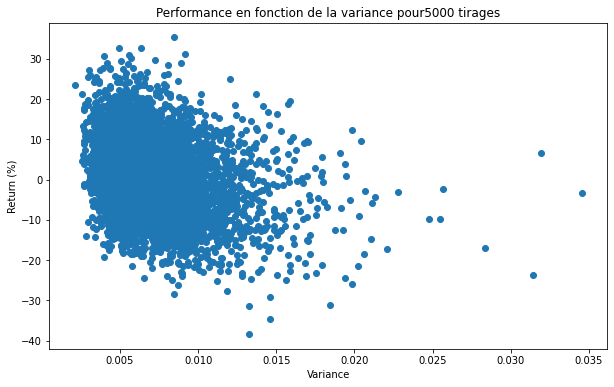

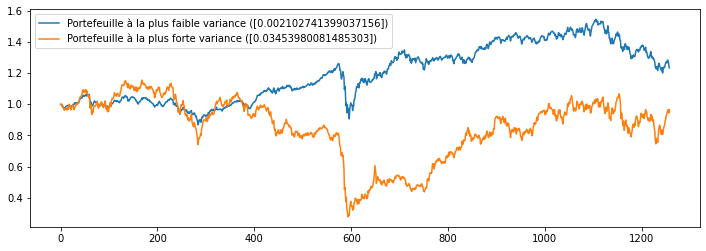

In [48]:
run_simulation(iters=5000, var=mooving_avg_var)

On observe ici une belle amélioration, avec une réelle différence de stabilité entre les portefeuilles à plus forte/faible variance.

Une autre intuition serait que puisque l'on voudrait atteindre un portefeuille dont la valeur se comporterai comme une droite (croissantes, sinon on shoprt tout..), ou une exponentielle, il pourrait être interessant de comparer le comportement de ce portefeuille à celui d'une droite de regression.

In [56]:
from sklearn.linear_model import LinearRegression

def linear_reg_var(serie):
    x = np.linspace(0, len(serie), len(serie)).reshape(-1, 1)
    modL = LinearRegression().fit(x, serie)
    residuals = np.mean(np.abs((serie - modL.predict(x))/serie))
    return residuals

<Figure size 1152x576 with 0 Axes>

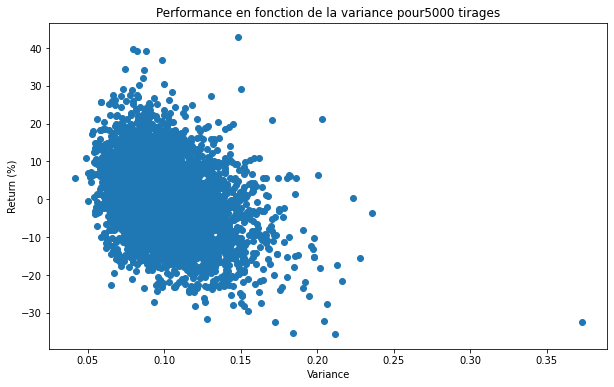

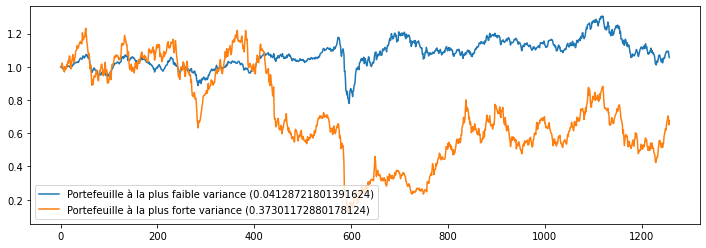

In [59]:
run_simulation(iters=5000, var=linear_reg_var)

Nous avons ici un magnifique portefeuille, qui bien que suivant l'ecrasement général de 2020, semble d'une stabilité plutôt fiable.
La performance n'est cependeant pas au rendez-vous, mais il sera ensuite possible de faire des compromis.